# Sketch Classifier - Custom Lightweight CNN
**26-Class Quick Draw Sketch Recognition**

**Built completely from scratch - No pre-built architectures!**

## Key Features:
- ✅ Custom lightweight CNN architecture
- ✅ Depthwise separable convolutions for efficiency
- ✅ ~1-2M parameters (very lightweight!)
- ✅ Trained from random initialization
- ✅ Perfect for web deployment

## Pipeline:
1. Data loading & preprocessing
2. Custom model architecture (depthwise separable convolutions)
3. Training from scratch
4. Evaluation & model saving
5. Web-ready export (TensorFlow.js)

In [57]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Configuration & Constants

In [58]:
# Configuration
DATA_DIR = "dataset/quickdraw_images_dedup"
IMG_SIZE = 255  # Smaller size for custom lightweight model
BATCH_SIZE = 32
EPOCHS = 50  # More epochs for training from scratch
LEARNING_RATE = 0.0001  # Higher initial LR for scratch training
VALIDATION_SPLIT = 0.15

# Class names (26 classes)
CLASS_NAMES = [
    "angel", "apple", "bat", "book", "candle", "castle", "cat", "cup", 
    "dog", "door", "fish", "flamingo", "hexagon", "lantern", "light bulb",
    "mailbox", "necklace", "octopus", "parachute", "pencil", "pig", 
    "skull", "swan", "sword", "table", "van"
]
NUM_CLASSES = len(CLASS_NAMES)

print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")

Number of classes: 26
Classes: ['angel', 'apple', 'bat', 'book', 'candle', 'castle', 'cat', 'cup', 'dog', 'door', 'fish', 'flamingo', 'hexagon', 'lantern', 'light bulb', 'mailbox', 'necklace', 'octopus', 'parachute', 'pencil', 'pig', 'skull', 'swan', 'sword', 'table', 'van']


## 2. Data Loading & Preprocessing

In [59]:
import shutil
import glob

# Create split directories
TRAIN_DIR = "dataset/train_split"
VAL_DIR = "dataset/val_split"

# Only create split if it doesn't exist
if not os.path.exists(TRAIN_DIR):
    print("Creating train/val split...")
    
    # Get all images per class
    for class_name in CLASS_NAMES:
        class_path = os.path.join(DATA_DIR, class_name)
        images = glob.glob(os.path.join(class_path, "*.png"))
        
        # Split 85/15
        train_imgs, val_imgs = train_test_split(
            images, 
            test_size=VALIDATION_SPLIT, 
            random_state=42
        )
        
        # Create class directories
        os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok=True)
        os.makedirs(os.path.join(VAL_DIR, class_name), exist_ok=True)
        
        # Copy files
        for img in train_imgs:
            shutil.copy2(img, os.path.join(TRAIN_DIR, class_name, os.path.basename(img)))
        for img in val_imgs:
            shutil.copy2(img, os.path.join(VAL_DIR, class_name, os.path.basename(img)))
        
        print(f"  {class_name}: {len(train_imgs)} train, {len(val_imgs)} val")
    
    print("✅ Split complete!")
else:
    print("✅ Using existing train/val split")

# Create separate generators WITHOUT validation_split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load from separate directories
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb',
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb',
    seed=42
)

print(f"\n✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {val_generator.samples}")
print(f"✅ Steps per epoch: {train_generator.samples // BATCH_SIZE}")

Creating train/val split...
  angel: 4250 train, 750 val
  apple: 4250 train, 750 val
  bat: 4250 train, 750 val
  book: 4250 train, 750 val
  candle: 4250 train, 750 val
  castle: 4250 train, 750 val
  cat: 4250 train, 750 val
  cup: 4250 train, 750 val
  dog: 4250 train, 750 val
  door: 4250 train, 750 val
  fish: 4250 train, 750 val
  flamingo: 4250 train, 750 val
  hexagon: 4250 train, 750 val
  lantern: 4250 train, 750 val
  light bulb: 4250 train, 750 val
  mailbox: 4250 train, 750 val
  necklace: 4250 train, 750 val
  octopus: 4250 train, 750 val
  parachute: 4250 train, 750 val
  pencil: 4250 train, 750 val
  pig: 4250 train, 750 val
  skull: 4250 train, 750 val
  swan: 4250 train, 750 val
  sword: 4250 train, 750 val
  table: 4250 train, 750 val
  van: 4250 train, 750 val
✅ Split complete!
Found 110500 images belonging to 26 classes.
Found 19500 images belonging to 26 classes.

✅ Training samples: 110500
✅ Validation samples: 19500
✅ Steps per epoch: 3453


## 3. Visualize Sample Data

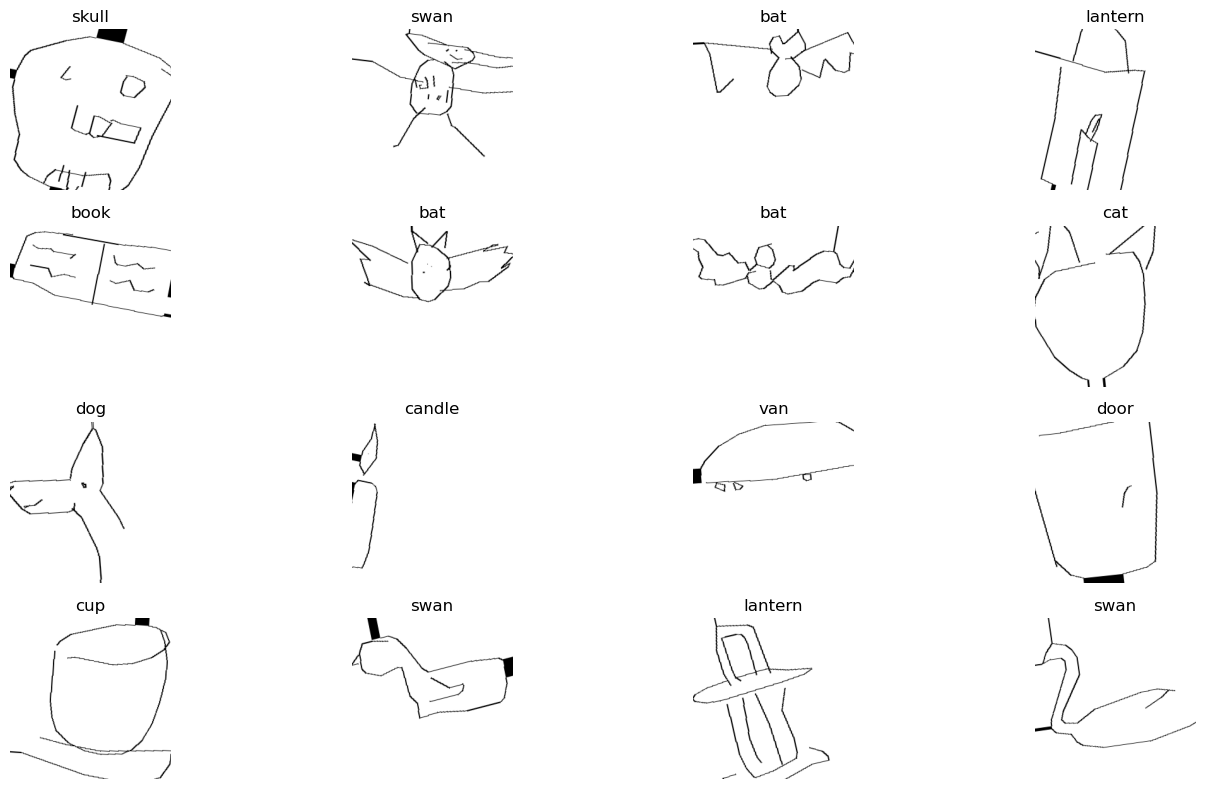

In [60]:
# Visualize a batch
sample_batch, sample_labels = next(train_generator)

plt.figure(figsize=(15, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_batch[i])
    class_idx = np.argmax(sample_labels[i])
    plt.title(CLASS_NAMES[class_idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Build Custom Lightweight CNN from Scratch

**Custom Architecture Features:**
- ✅ Built entirely from basic Keras layers (no pre-built models)
- ✅ Uses **Depthwise Separable Convolutions** for efficiency
- ✅ ~1-2M parameters (very lightweight!)
- ✅ Fast inference for web deployment
- ✅ Inspired by MobileNet principles but coded from scratch

In [61]:
def depthwise_separable_conv(x, filters, kernel_size=3, strides=1, name=''):
    """
    Depthwise Separable Convolution - key to lightweight models!
    Splits convolution into depthwise (spatial) + pointwise (channel-wise)
    This reduces parameters significantly compared to regular convolution
    """
    # Depthwise convolution (spatial filtering)
    x = layers.DepthwiseConv2D(
        kernel_size=kernel_size,
        strides=strides,
        padding='same',
        use_bias=False,
        name=f'{name}_dwconv'
    )(x)
    x = layers.BatchNormalization(name=f'{name}_bn1')(x)
    x = layers.ReLU(name=f'{name}_relu1')(x)
    
    # Pointwise convolution (channel mixing)
    x = layers.Conv2D(
        filters,
        kernel_size=1,
        strides=1,
        padding='same',
        use_bias=False,
        name=f'{name}_pwconv'
    )(x)
    x = layers.BatchNormalization(name=f'{name}_bn2')(x)
    x = layers.ReLU(name=f'{name}_relu2')(x)
    
    return x


def build_model(num_classes=NUM_CLASSES, img_size=IMG_SIZE):
    """
    Custom Lightweight CNN Architecture built completely from scratch!
    Uses depthwise separable convolutions for efficiency
    No pre-built architectures - everything coded from basic Keras layers
    """
    inputs = layers.Input(shape=(img_size, img_size, 3), name='input')
    
    # Initial convolution layer
    x = layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False, name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    # Shape: (64, 64, 32)
    
    # Block 1
    x = depthwise_separable_conv(x, 64, strides=1, name='block1')
    # Shape: (64, 64, 64)
    
    # Block 2 - downsample
    x = depthwise_separable_conv(x, 128, strides=2, name='block2a')
    x = depthwise_separable_conv(x, 128, strides=1, name='block2b')
    # Shape: (32, 32, 128)
    
    # Block 3 - downsample
    x = depthwise_separable_conv(x, 256, strides=2, name='block3a')
    x = depthwise_separable_conv(x, 256, strides=1, name='block3b')
    # Shape: (16, 16, 256)
    
    # Block 4 - downsample
    x = depthwise_separable_conv(x, 512, strides=2, name='block4a')
    x = depthwise_separable_conv(x, 512, strides=1, name='block4b')
    x = depthwise_separable_conv(x, 512, strides=1, name='block4c')
    # Shape: (8, 8, 512)
    
    # Global pooling and classification head
    x = layers.GlobalAveragePooling2D(name='global_pool')(x)
    x = layers.Dropout(0.5, name='dropout1')(x)
    x = layers.Dense(128, activation='relu', name='fc1')(x)
    x = layers.BatchNormalization(name='bn_fc')(x)
    x = layers.Dropout(0.4, name='dropout2')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='CustomLightweightCNN')
    
    return model

# Build model
model = build_model()
model.summary()

total_params = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"\n🎨 Custom Lightweight CNN built from scratch!")
print(f"⚡ All {len(model.trainable_weights)} parameters will be trained from random initialization")
print(f"📦 Model size: ~{total_params / 1e6:.2f}M parameters")
print(f"🚀 Architecture: Depthwise Separable Convolutions (no pre-trained weights)")

Model: "CustomLightweightCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 255, 255, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 bn1 (BatchNormalization)    (None, 128, 128, 32)      128       
                                                                 
 relu1 (ReLU)                (None, 128, 128, 32)      0         
                                                                 
 block1_dwconv (DepthwiseCon  (None, 128, 128, 32)     288       
 v2D)                                                            
                                                                 
 block1_bn1 (BatchNormalizat  (None, 128, 128, 32)     128       
 ion)                                         

## 5. Compile Model

In [62]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')]
)

print("Model compiled successfully!")

Model compiled successfully!


## 6. Setup Callbacks

In [63]:
import time

# Custom callback to show detailed progress
class DetailedProgressCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_start_time = None
        
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        print(f"\n{'='*60}")
        print(f"📍 Starting Epoch {epoch + 1}/{self.params['epochs']}")
        print(f"{'='*60}")
        
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        print(f"\n{'='*60}")
        print(f"✅ Epoch {epoch + 1} Complete - Time: {epoch_time:.2f}s")
        print(f"📈 Training   - Loss: {logs['loss']:.4f} | Acc: {logs['accuracy']*100:.2f}%")
        print(f"📊 Validation - Loss: {logs['val_loss']:.4f} | Acc: {logs['val_accuracy']*100:.2f}%")
        print(f"🎯 Top-3 Accuracy: {logs['val_top3_accuracy']*100:.2f}%")
        print(f"⚙️  Learning Rate: {float(self.model.optimizer.lr):.6f}")
        print(f"{'='*60}\n")
        
    def on_train_batch_end(self, batch, logs=None):
        # Show progress every 500 batches
        if batch > 0 and batch % 500 == 0:
            print(f"  ⏳ Batch {batch}/{self.params['steps']} - Loss: {logs['loss']:.4f} | Acc: {logs['accuracy']*100:.2f}%")

# Create callbacks
callbacks = [
    DetailedProgressCallback(),  # Custom detailed output
    keras.callbacks.ModelCheckpoint(
        'models/sketch_custom_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,  # More patience for scratch training
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,  # More patience before reducing LR
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.CSVLogger('models/training_log.csv', append=False)  # Save training log
]

# Create models directory
os.makedirs('models', exist_ok=True)
print("✅ Callbacks configured with detailed progress tracking!")
print("📝 Training log will be saved to: models/training_log.csv")

✅ Callbacks configured with detailed progress tracking!
📝 Training log will be saved to: models/training_log.csv


## 7. Train Model (From Scratch)

In [ ]:
# Train from scratch - single phase!
print("\n" + "="*60)
print("🚀 TRAINING CUSTOM LIGHTWEIGHT CNN FROM SCRATCH")
print("Custom architecture using depthwise separable convolutions")
print("Training all layers with random initialization")
print("="*60 + "\n")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)


🚀 TRAINING CUSTOM LIGHTWEIGHT CNN FROM SCRATCH
Custom architecture using depthwise separable convolutions
Training all layers with random initialization


📍 Starting Epoch 1/50
Epoch 1/50
3454/3454 [==============================] - ETA: 0s - loss: 2.7257 - accuracy: 0.2283 - top3_accuracy: 0.4616
✅ Epoch 1 Complete - Time: 3832.22s
📈 Training   - Loss: 2.7257 | Acc: 22.83%
📊 Validation - Loss: 6.0450 | Acc: 7.47%
🎯 Top-3 Accuracy: 21.24%
⚙️  Learning Rate: 0.000100


Epoch 1: val_accuracy improved from -inf to 0.07472, saving model to models\sketch_custom_best.h5
3454/3454 [==============================] - 3832s 1s/step - loss: 2.7257 - accuracy: 0.2283 - top3_accuracy: 0.4616 - val_loss: 6.0450 - val_accuracy: 0.0747 - val_top3_accuracy: 0.2124 - lr: 1.0000e-04

📍 Starting Epoch 2/50
Epoch 2/50
 699/3454 [=====>........................] - ETA: 14:49 - loss: 1.9189 - accuracy: 0.4223 - top3_accuracy: 0.6993

## 8. Training Complete!

In [ ]:
# Training is complete!
print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("Custom lightweight CNN trained completely from scratch")
print("="*60 + "\n")

# Show training summary
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")

## 9. Plot Training History

In [ ]:
def plot_training_history(training_history):
    """Plot training and validation metrics"""
    hist = training_history.history
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    axes[0].plot(hist['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(hist['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title('Model Accuracy (Custom CNN from Scratch)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(hist['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(hist['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title('Model Loss (Custom CNN from Scratch)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('models/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(history)

## 10. Evaluate Model

In [ ]:
# Evaluate on validation set
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50 + "\n")

val_loss, val_accuracy, val_top3 = model.evaluate(val_generator, verbose=1)

print(f"\n📊 Final Metrics:")
print(f"  Validation Loss: {val_loss:.4f}")
print(f"  Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"  Top-3 Accuracy: {val_top3*100:.2f}%")

## 11. Confusion Matrix & Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Sketch Classifier', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('models/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Save Model

In [ ]:
# Save final model in multiple formats
model.save('models/sketch_classifier_final.h5')
model.save('models/sketch_classifier_final.keras')

# Save as SavedModel format (for TensorFlow.js)
model.export('models/sketch_classifier_savedmodel')

# Save model summary
with open('models/model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

print("✅ Model saved successfully!")
print("\nSaved formats:")
print("  - H5: models/sketch_classifier_final.h5")
print("  - Keras: models/sketch_classifier_final.keras")
print("  - SavedModel: models/sketch_classifier_savedmodel/")

## 13. Prediction Function

In [ ]:
from PIL import Image

def predict_sketch(image_path, model, top_k=3):
    """
    Predict sketch class from image path
    
    Args:
        image_path: Path to image file
        model: Trained Keras model
        top_k: Number of top predictions to return
    
    Returns:
        Dictionary with predictions and probabilities
    """
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    predictions = model.predict(img_array, verbose=0)[0]
    
    # Get top-k predictions
    top_indices = np.argsort(predictions)[-top_k:][::-1]
    
    results = {
        'predictions': [
            {
                'class': CLASS_NAMES[idx],
                'confidence': float(predictions[idx]),
                'confidence_percent': f"{predictions[idx]*100:.2f}%"
            }
            for idx in top_indices
        ],
        'top_class': CLASS_NAMES[top_indices[0]],
        'top_confidence': float(predictions[top_indices[0]])
    }
    
    return results

# Test function
test_image = next(Path(DATA_DIR).glob('**/*.png'))
result = predict_sketch(str(test_image), model)

print(f"\n🎨 Test Prediction:")
print(f"Image: {test_image.name}")
print(f"\nTop Prediction: {result['top_class']} ({result['top_confidence']*100:.2f}%)")
print(f"\nAll Predictions:")
for pred in result['predictions']:
    print(f"  {pred['class']:15s}: {pred['confidence_percent']}")

## 14. Visualize Predictions

In [ ]:
def visualize_predictions(model, num_samples=12):
    """
    Visualize model predictions on random validation samples
    """
    # Get random batch
    sample_batch, sample_labels = next(val_generator)
    predictions = model.predict(sample_batch, verbose=0)
    
    plt.figure(figsize=(18, 12))
    for i in range(min(num_samples, len(sample_batch))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(sample_batch[i])
        
        true_idx = np.argmax(sample_labels[i])
        pred_idx = np.argmax(predictions[i])
        confidence = predictions[i][pred_idx]
        
        true_label = CLASS_NAMES[true_idx]
        pred_label = CLASS_NAMES[pred_idx]
        
        # Color: green if correct, red if wrong
        color = 'green' if true_idx == pred_idx else 'red'
        
        plt.title(f"True: {true_label}\nPred: {pred_label}\n({confidence*100:.1f}%)",
                 color=color, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('models/sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions(model)

## 15. Convert to TensorFlow.js (for Web Deployment)

In [ ]:
# Install tensorflowjs converter if not already installed
!pip install tensorflowjs

# Convert model to TensorFlow.js format
!tensorflowjs_converter \
    --input_format=keras \
    --output_format=tfjs_graph_model \
    models/sketch_classifier_final.h5 \
    models/tfjs_model

print("\n✅ Model converted to TensorFlow.js!")
print("Location: models/tfjs_model/")
print("\nYou can now use this model in your web application!")

## 16. Model Summary & Deployment Notes

In [ ]:
import json

# Create deployment info
deployment_info = {
    "model_name": "QuickDraw Sketch Classifier",
    "architecture": "Custom Lightweight CNN with Depthwise Separable Convolutions",
    "training_method": "Trained completely from scratch - no pre-built architecture or pre-trained weights",
    "num_classes": NUM_CLASSES,
    "class_names": CLASS_NAMES,
    "input_size": IMG_SIZE,
    "input_shape": [IMG_SIZE, IMG_SIZE, 3],
    "preprocessing": "Rescale to [0, 1]",
    "training_samples": train_generator.samples,
    "validation_samples": val_generator.samples,
    "validation_accuracy": float(val_accuracy),
    "validation_top3_accuracy": float(val_top3),
    "model_size_mb": os.path.getsize('models/sketch_classifier_final.h5') / (1024 * 1024),
}

# Save deployment info
with open('models/deployment_info.json', 'w') as f:
    json.dump(deployment_info, f, indent=2)

print("\n" + "="*60)
print("MODEL DEPLOYMENT INFO")
print("="*60)
print(json.dumps(deployment_info, indent=2))
print("="*60)

print("\n📦 All files saved to 'models/' directory")
print("\n🚀 Ready for web deployment!")

## 17. Export Class Names for Web App

In [ ]:
# Save class names as JSON for web app
class_mapping = {i: name for i, name in enumerate(CLASS_NAMES)}

with open('models/class_names.json', 'w') as f:
    json.dump({
        'classes': CLASS_NAMES,
        'mapping': class_mapping
    }, f, indent=2)

print("✅ Class names exported to models/class_names.json")